In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/eye_quality/processed.zip", 'r')
zip_ref.extractall("/content/drive/MyDrive/Colab Notebooks/eye_quality/")
zip_ref.close()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install pytorch-lightning timm torchinfo

In [ ]:
root_dir = '/content/drive/MyDrive/Colab Notebooks/eye_quality'

In [1]:
root_dir = '/home/tiurin/projects/ExampleProject/Temp/'

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import sys
sys.path.append('/home/tiurin/projects/ExampleProject/Temp/code/eye_quality/')

In [4]:
import dataset_utils

In [5]:
import evaluation_utils

In [6]:
from torch.utils.data import Subset,DataLoader
from torchvision import transforms, utils
import torchvision
import torch

In [7]:
import torch.nn.functional as F

In [8]:
import os

In [9]:
import numpy as np

In [10]:
import pytorch_lightning as pl

In [11]:
# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Global seed set to 42


In [12]:
train_set, val_set, class_weights = dataset_utils.get_dataset(train_percent=0.9, 
                                                              rotation_transform=True,
                                                             zoom_augment=True)

#train_set = Subset(train_set, torch.arange(100))
#val_set = Subset(val_set, torch.arange(100))

train_loader = DataLoader(train_set, batch_size=32, shuffle=True,
                               drop_last=True, pin_memory=True, num_workers=8)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False,
                             drop_last=False, num_workers=8)

In [13]:
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


In [14]:
import torchinfo

In [15]:
from torch import optim, nn
import timm
import torchmetrics

In [16]:
import torch.nn.functional as F

In [18]:
class EyeQualityModel(pl.LightningModule):
    def __init__(self, class_weights=None):
        super().__init__()
        
        self.net = timm.create_model('efficientnet_es', pretrained=True, in_chans=1)
        self.net.classifier = nn.Identity()
        self.classifier = nn.Linear(1280, 2)
        
        torch.nn.init.xavier_uniform_(self.classifier.weight)
        self.classifier.bias.data.fill_(0.0)

        self.class_weights = class_weights
        self.example_input_array = train_set[0][1].unsqueeze(0)
        
    def forward(self, x):
        x = self.net(x)
        x = self.classifier(x)
        return x
    
    def ordinal_regression(self, predictions, targets):
        modified_target = torch.zeros_like(predictions)
        for i, target in enumerate(targets):
            if target > 0:
                modified_target[i, 0:target] = 1
        loss = torch.nn.functional.binary_cross_entropy_with_logits(predictions,
                                                                    modified_target,
                                                                    reduction='none').sum(dim=1)
        if self.class_weights is not None:
            for i, target in enumerate(targets):
                loss[i] *= self.class_weights[target]
        return loss.mean()
    
    def predict(self, img):
        x = self.forward(img)
        c = self.prediction2label(x)
        return c

    def prediction2label(self, pred: np.ndarray):
        pred = torch.sigmoid(pred)
        return torch.clamp((pred > 0.5).cumprod(axis=1).sum(axis=1), min=0)
    
    def training_step(self, batch, batch_idx):
        class_lbl, img = batch
        c = self.forward(img)
        loss = self.ordinal_regression(c, class_lbl)
        self.log("train_loss", loss)       
        return loss
    
    def validation_step(self, batch, batch_idx):
        class_lbl, img = batch
        c = self.forward(img)
        loss = self.ordinal_regression(c, class_lbl)
        self.log("val_loss", loss.mean())
        res = torch.vstack([self.prediction2label(c), class_lbl])
        return res
    
    def validation_epoch_end(self, validation_step_outputs):
        all_preds = torch.hstack(validation_step_outputs)
        conf_mat = evaluation_utils.get_confusion_matrix(all_preds[0,:], all_preds[1,:])
        self.log("val_accuracy", evaluation_utils.accuracy(conf_mat))
        self.log("val_recall", evaluation_utils.recall(conf_mat))
        self.log("val_precision", evaluation_utils.precision(conf_mat))
        self.log("val_f1_score", evaluation_utils.f1_score(conf_mat))
        self.log("val_class_accuracy_0", evaluation_utils.class_accuracy(conf_mat, 0))
        self.log("val_class_accuracy_1", evaluation_utils.class_accuracy(conf_mat, 1))
        self.log("val_class_accuracy_2", evaluation_utils.class_accuracy(conf_mat, 2))
        
        fig = evaluation_utils.plot_confusion_matrix(conf_mat, ['Reject', 'Usable', 'Good'])
        img = evaluation_utils.plot_to_image(fig)
        
        img = img.astype(float) / 255
        self.logger.experiment.add_image("Confusion matrix", img, self.current_epoch, dataformats="CHW")

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
        return [optimizer], [scheduler]
    

In [19]:
model = EyeQualityModel(class_weights)
model = model.to(device)

In [20]:
torchinfo.summary(model, (1, 1, 400, 400))

Layer (type:depth-idx)                             Output Shape              Param #
EyeQualityModel                                    [1, 2]                    --
├─EfficientNet: 1-1                                [1, 1280]                 --
│    └─Conv2d: 2-1                                 [1, 32, 200, 200]         288
│    └─BatchNormAct2d: 2-2                         [1, 32, 200, 200]         64
│    │    └─Identity: 3-1                          [1, 32, 200, 200]         --
│    │    └─ReLU: 3-2                              [1, 32, 200, 200]         --
│    └─Sequential: 2-3                             [1, 192, 13, 13]          --
│    │    └─Sequential: 3-3                        [1, 24, 200, 200]         30,192
│    │    └─Sequential: 3-4                        [1, 32, 100, 100]         130,560
│    │    └─Sequential: 3-5                        [1, 48, 50, 50]           642,176
│    │    └─Sequential: 3-6                        [1, 96, 25, 25]           746,304
│    │    └─Seq

In [21]:
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

In [22]:
checkpoint_path = os.path.join(root_dir, 'training')
model_name = 'eyeq_model_big_stn'
root_dir = os.path.join(checkpoint_path, model_name)

In [ ]:
trainer = pl.Trainer(default_root_dir=root_dir,
    accelerator="gpu" if str(device).startswith("cuda") else "cpu",
    devices=[device.index],
    max_epochs=10,
    log_every_n_steps = 50,
    callbacks=[ModelCheckpoint(dirpath=root_dir, 
                filename=model_name+'-{epoch}-{val_accuracy:.2f}', 
                save_weights_only=True, 
                save_last=True),
                LearningRateMonitor("epoch")],
    check_val_every_n_epoch=1)

trainer.logger._log_graph = True
trainer.logger._default_hp_metric = None

trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/tiurin/anaconda3/envs/mri_gpu/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /share/data_rechenknecht03_2/students/tiurin/projects/ExampleProject/Temp/training/eyeq_model_big_stn exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name       | Type         | Params | In sizes         | Out sizes
---------------------------------------------------------------------------
0 | net        | EfficientNet | 4.2 M  | [1, 1, 400, 400] | [1, 1280]
1 | classifier | Linear       | 2.6 K  | [1, 1280]        | [1, 2]   
---------------------------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params


Sanity Checking: 0it [00:00, ?it/s]

/home/tiurin/projects/ExampleProject/Temp/code/eye_quality/evaluation_utils.py:104: RuntimeWarning: invalid value encountered in long_scalars
  averageRecall += confusionMat[idx,idx]/np.sum(confusionMat[idx,:])
/home/tiurin/projects/ExampleProject/Temp/code/eye_quality/evaluation_utils.py:123: RuntimeWarning: invalid value encountered in long_scalars
  return confusion_mat[class_num, class_num]/confusion_mat[class_num,:].sum()


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
ckpt = torch.load('/home/tiurin/projects/ExampleProject/Temp/training/eyeq_model-epoch=5-val_accuracy=0.90.ckpt', 
                  map_location=device)
model.load_state_dict(ckpt['state_dict'])

In [109]:
import matplotlib.pyplot as plt

In [32]:
model = model.eval()

In [110]:
s = val_set[2000]
s[0]

2

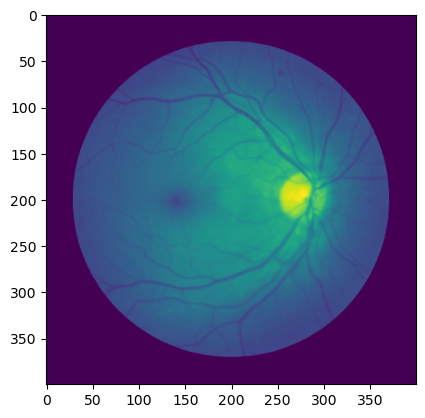

In [113]:
plt.imshow(dataset_utils.prepare_for_vis(s[1]))

In [36]:
x_tnsfm = model.stn(s[1].unsqueeze(0).to(device))

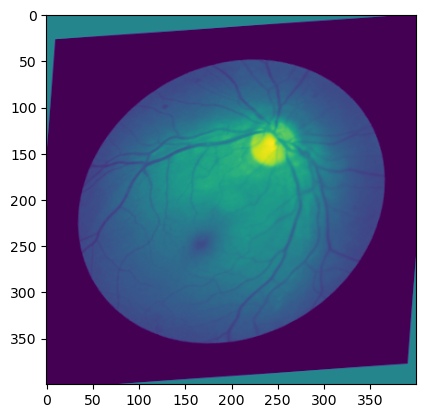

In [38]:
plt.imshow(dataset_utils.prepare_for_vis(x_tnsfm.squeeze(0)))

In [39]:
from tqdm import tqdm

In [172]:
confusion_mat, cofusion_images = evaluation_utils.get_confusion_matrix(model, val_loader, device)

In [173]:
confusion_mat

array([[ 498,   53,    3],
       [  63,  504,   77],
       [   2,  109, 1571]])

In [174]:
fig = evaluation_utils.plot_confusion_matrix(confusion_mat, ['Reject', 'Usable', 'Good'])
img = evaluation_utils.plot_to_image(fig)

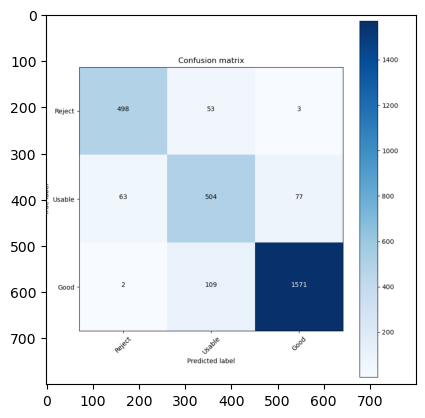

In [175]:
plt.imshow(img.transpose(1,2,0))

In [176]:
conf_img_list = [cofusion_images[j][i] for i in range(3) for j in range(3)]
img_grid = evaluation_utils.make_image_grid(conf_img_list)

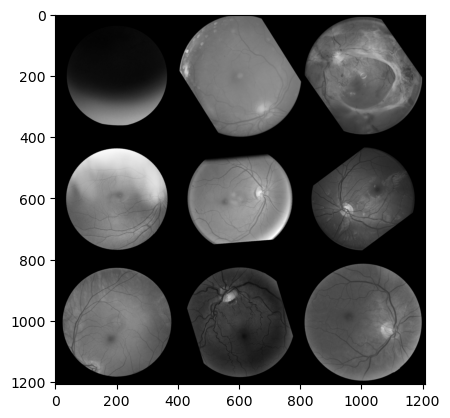

In [179]:
plt.imshow(img_grid.transpose(1,2,0))